# Calendar integration, partB

This Jupyter Notebook brings together all file types on Inside Airbnb (listings.csv.gz, calendar.csv.gz, reviews.csv.gz) to form a dataset on nightly property pricing, availability, and booking transactions. Using the listings files, this dataset also includes property characteristics such as the number of bedrooms, the room type, its review score and host characteristics.

The code below relies on previously run Notebooks “1st_stage_panel_data_cleaning.ipynb” and “Calendar_integration_partA.ipynb”. In particular, this notebook will load in:  
* [CITY]_1stStageClean.csv.gz file created in the “1st_stage_panel_data_cleaning” notebook
* [CITY]_rejoined_booked_df.csv  created in the “Calendar_integration_partA” notebook

Review files must also be saved in the Raw Data path in order for the code below to run. 

In [1]:
import os
import pandas as pd
import numpy as np
import datetime
from functools import reduce
import time

# Enable garbage collection module for memory purposes
import gc
gc.enable()

In [2]:
# Select city to work with

city_folder = 'united-states_portland/'
city_abbrev = 'POR'

In [3]:
# Universal directory setup
cwd1 = os.getcwd() 

# Go up one directory level
os.chdir('..')
cwd2 = os.getcwd()

# Set paths
graphics_folder = cwd2 + '/3. Graphics/'
data_path = cwd2 + '/Saved data/'
csv_path = cwd2 + '/0. Raw data/' + city_folder

# Revert to preliminary directory
os.chdir(cwd1)

## 1. Review assumption

I make an assumption that a property must have been 'active' tend days before it recieved a review. This assumption can be adjusted by a researcher in the follow cell.

In [4]:
# Set how many days before a review a property is assumed to be active. 
N_days_before = 10

In [5]:
calFiles = []
fileNames = os.listdir(csv_path)
for fileNames in fileNames:
    if fileNames.endswith("calendar.csv.gz"):
        calFiles.append(fileNames)      

file_dates = []

for i in range(len(calFiles)):
    file_dates.append(calFiles[i].split('_')[2])
    
file_dates = np.sort(np.array(file_dates).astype('datetime64[M]'))

print(file_dates)

['2015-03' '2015-05' '2015-09' '2015-11' '2015-12' '2016-01' '2016-02'
 '2016-04' '2016-05' '2016-06' '2016-07' '2016-08' '2016-09' '2016-11'
 '2016-12' '2017-01' '2017-02' '2017-03' '2017-04' '2017-05' '2017-06'
 '2017-07' '2017-08' '2017-09' '2017-10' '2017-11' '2017-12' '2018-01'
 '2018-02' '2018-04' '2018-05' '2018-07' '2018-08' '2018-09' '2018-10'
 '2018-11' '2018-12' '2019-01' '2019-02']


# 2. Upload listings dataframe/cross sectional file

In [6]:
os.chdir(data_path)
dateCols =['last_scraped', 'host_since', 'first_review', 'last_review']

listings_df = pd.read_csv(city_abbrev + '_1stStageClean.csv.gz', compression = 'gzip', 
                          low_memory=False, parse_dates=dateCols)

clean_months = listings_df['scrape_batch'].astype('datetime64[M]').unique().astype('datetime64[M]')

In [7]:
# Add free parking and pool amenities
parking_search = ['Free parking on premises']
listings_df.loc[:, 'free_park'] = (listings_df['amenities'].str.contains('|'.join(parking_search), na=False)*1).values

pool_search = ['pool', 'Pool']
listings_df.loc[:, 'pool'] = (listings_df['amenities'].str.contains('|'.join(pool_search), na=False)*1).values

os.chdir(csv_path)

In [8]:
# Loading the booked_df that is created by previous partA Jupyter Notebook
os.chdir(data_path)
booked_df = pd.read_csv(city_abbrev + '_rejoined_booked_df.csv.gz', low_memory=False, compression='gzip')
booked_df['res_date'] = booked_df['res_date'].astype('datetime64[D]')
booked_df.head(5)

,booked,id,res_date,never_avail,price,last_date,all_prices,final_prices,seen_avail,week_yr,mo_yr
0,False,9356,2015-09-02,False,NaN,NaN,70.0,70.0,1,2015-35,2015-09
1,False,45890,2015-09-02,True,NaN,NaN,NaN,NaN,0,2015-35,2015-09
2,False,47326,2015-09-02,True,NaN,NaN,NaN,NaN,0,2015-35,2015-09
3,False,222209,2015-09-02,False,NaN,NaN,118.0,118.0,1,2015-35,2015-09
4,False,47674,2015-09-02,True,NaN,NaN,NaN,NaN,0,2015-35,2015-09


----

# 3. Incorporating review files

If a property receives a review then it is assumed that it was available for a certain number of days prior to that review.

The commented out code in this section creates the review dataframe as long as you have all of the review scrapes in the "csv_path" folder. After it has been created, all that needs to be done is to load it in the next section.

### a) Collect review csv names

In [9]:
# Collect reviews csvs names

os.chdir(csv_path)
revFiles = []
fileNames = os.listdir(csv_path)
for fileNames in fileNames:
    if fileNames.endswith("reviews.csv.gz"):
        revFiles.append(fileNames)
        
revFiles = np.sort(revFiles)    

### b) Create a function to concatenate review dataframes

In [10]:
def concat_spreadsheets(possible_files, eligible_files):
    sheets_df = []

    for filename in revFiles[np.isin(possible_files, possible_files)]:
        df = pd.read_csv(filename, index_col = None, header=0)
        sheets_df.append(df)

    sheets_df = pd.concat(sheets_df, axis=0, ignore_index=True)
    return sheets_df

### c) Run the function and save a compressed dataframe with all unique reviews

In [11]:
# DO NOT DELETE, THIS CREATES THE AGGREGATE REVIEW FILE

# ============================================================
# CREATE REVS FILE

collected_revs = concat_spreadsheets(file_dates, clean_months)
uniq_revs = collected_revs.drop_duplicates()
print(len(collected_revs), len(uniq_revs))
uniq_revs.to_csv(city_abbrev + '_Revs.csv.gz', compression='gzip', index=False) 

# ============================================================
# LOAD IN ALREADY CREATED REVS FILE

# This cell imports the compressed review datafame created above. 

#os.chdir(csv_path)

#uniq_revs = pd.read_csv(city_abbrev + '_Revs.csv.gz', compression='gzip')

#os.chdir(data_path)

7090339 497526


------

In [12]:
# Drop the listing IDs that are not in the calendar files
unique_ids = booked_df.id.unique()
uniq_revs = uniq_revs[uniq_revs.listing_id.isin(unique_ids)]

------

In [13]:
res_date_min, res_date_max = booked_df['res_date'].min(), booked_df['res_date'].max() 
revs_df = uniq_revs[['listing_id', 'date']]

revs_df.loc[:, 'date'] = revs_df['date'].astype('datetime64[D]')
mask = (revs_df['date'] >= res_date_min) & (revs_df['date'] <= res_date_max)
revs_df = revs_df[mask]
revs_short = revs_df 

# Dataframe of res_dates
reviews_file = revs_short
N_reviews = len(reviews_file)

reviews_file.head(5)

/Users/Lauri/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,listing_id,date
93710,6541045,2015-09-02
93937,6290791,2015-09-02
94091,2660141,2015-09-02
95435,6361965,2015-09-02
97143,6985337,2015-09-02


# 4. Active property dataframe creation

Much like the review code, the commented out block below creates a pandas dataframe that tracks the dates during which a property is active.

Once the dataframe is created, it can just be loaded in, meaning you can comment out the code below.

In [14]:
# Here we identify the unique dates from the reviews_file and identify the 
# index for every row of the reviews_file that maps to the unique dates file. 
# This allows one to avoid duplicate calculations for identical dates.

my_dates = reviews_file['date'].astype('datetime64[D]')

unq_dates = pd.DataFrame([my_dates.unique()]).T
unq_dates.columns = ['unq_dates']
unq_dates = unq_dates.sort_values(by='unq_dates').reset_index(drop=True)

# Identify the valid index in the unq_arr for the non-unique list of dates

dates_arr = my_dates.values
unq_arr = np.concatenate(unq_dates.values)

sorter = np.argsort(unq_arr)
my_indices = sorter[np.searchsorted(unq_arr, dates_arr, sorter=sorter)]

my_dates = pd.DataFrame(my_dates.values, columns = ['dates'])
my_dates.loc[:, "unq_ind"] = my_indices
unq_dates.loc[np.r_[my_dates['unq_ind']], :]

# Create all of the date ranges that we want to work with.

unq_dates.loc[:,"start"] = unq_dates['unq_dates'] - datetime.timedelta(days=N_days_before)

days_before = []

for i in range(len(unq_dates)):
      days_before.append(pd.date_range(unq_dates['start'][i], unq_dates['unq_dates'][i], closed='left'))
    
# # Here we create a dataframe that has all of the listing data

active_dates = np.concatenate(np.array(days_before)[my_dates['unq_ind'].values].astype('datetime64[D]'))
my_date_ids = np.reshape(pd.concat([reviews_file['listing_id']]*N_days_before, axis=1).values, (N_days_before*N_reviews,1))
my_date_ids = np.concatenate(my_date_ids)

active_df = pd.DataFrame([my_date_ids, active_dates]).T
active_df.columns = ['id', 'rev_active_date']

active_day_int = active_df['rev_active_date'].view(np.int64)//(10**3)
active_df.loc[:, "dy_key"] = active_day_int + active_df['id']
del active_day_int

# active_df.loc[:, "key"] = active_df['id'].astype(str) + ":" + active_df['date'].astype(str)

print(N_reviews)

active_df.to_csv('active_dates'+ str(N_days_before) + ".csv.gz", compression = 'gzip', index=False)

397172


In [15]:
# DO NOT DELETE. my_active_file is created by the code that is commented out below! 
# [Note: Need to be in the 0. Raw data directory for this to work.]

#my_active_file = "active_dates" + str(N_days_before) + ".csv.gz"

#active_df = pd.read_csv(my_active_file, compression='gzip', parse_dates=['date'])
#active_df.tail(5)

# 5. Merge

## (a) Create merge key in the booked_df
* Need keys for date and month

In [16]:
booked_df_day_int = booked_df['res_date'].astype('datetime64[ns]').values.astype(np.int64)//(10**3)
booked_df.loc[:, 'dy_key'] = booked_df_day_int + booked_df['id']

del booked_df_day_int

In [17]:
booked_mo_yr_int64 = booked_df['mo_yr'].astype('datetime64').values.view(np.int64)//(10**3)
booked_df.loc[:, "mo_key"] = booked_mo_yr_int64 + booked_df['id']
del booked_mo_yr_int64

## (b) Create merge key in the listings_df

In [18]:
listings_df['batch_YRMO'] = listings_df['batch_YRMO'].astype('datetime64').dt.to_period('M')

listings_mask = ((listings_df['batch_YRMO'] >= booked_df['mo_yr'].min()) & 
                 (listings_df['batch_YRMO'] <= booked_df['mo_yr'].max()))

listings_df = listings_df[listings_mask]

In [19]:
listings_df_mo_yr_int64 = listings_df['batch_YRMO'].dt.to_timestamp().values.astype(np.int64)//(10**3)
listings_df.loc[:, "mo_key"] = listings_df_mo_yr_int64 + listings_df['id']

del listings_df_mo_yr_int64

## (c) Merge calendar data and listings data

In [20]:
# Rename prices to make it clearer
booked_df = booked_df.rename(columns={'final_prices':"calendar_price"})
listings_df = listings_df.rename(columns={'price':"headline_price"})

In [21]:
# Merge time-varying variables from the panel to the booked_df dataframe. Prices here are "headline prices".
list_month_merge = booked_df.merge(listings_df[['mo_key', 'List_month', 'Listlead1', 
                                                'Listlag1', 'headline_price', 'cleaning_fee', 'host_listings_count', 'cum_sum',
                                                 'bedrooms', 'room_type', 'neighbourhood', 'zipcode', # I wanted to have this last row separte 
                                               'free_park', 'pool', 'host_since', 'review_scores_rating', 'number_of_reviews']], # These two are new here
                                   left_on='mo_key', right_on='mo_key', how='left')

In [22]:
# Clear some memory
del booked_df
del listings_df
del revs_df
del listings_mask
del revs_short

In [23]:
print(len(list_month_merge))
list_month_merge.head(5)

13304620


,booked,id,res_date,never_avail,price,last_date,all_prices,calendar_price,seen_avail,week_yr,...,cum_sum,bedrooms,room_type,neighbourhood,zipcode,free_park,pool,host_since,review_scores_rating,number_of_reviews
0,False,9356,2015-09-02,False,NaN,NaN,70.0,70.0,1,2015-35,...,1.0,2.0,Entire home/apt,Woodlawn,97211.0,0.0,0.0,2009-08-06,97.0,57.0
1,False,45890,2015-09-02,True,NaN,NaN,NaN,NaN,0,2015-35,...,2.0,1.0,Entire home/apt,Roseway,97213.0,0.0,0.0,2010-07-24,97.0,92.0
2,False,47326,2015-09-02,True,NaN,NaN,NaN,NaN,0,2015-35,...,2.0,1.0,Private room,Overlook,97217.0,0.0,0.0,2010-08-26,89.0,221.0
3,False,222209,2015-09-02,False,NaN,NaN,118.0,118.0,1,2015-35,...,3.0,1.0,Private room,Forest Park,97229.0,0.0,0.0,2011-07-29,92.0,20.0
4,False,47674,2015-09-02,True,NaN,NaN,NaN,NaN,0,2015-35,...,1.0,1.0,Entire home/apt,Buckman,97214.0,0.0,0.0,2010-05-07,NaN,NaN


## (d) Merge review data with previous merge

In [24]:
N_chunk_ids = 25 # This chunk size determined through trial and error
N_total_chunks = int(np.ceil(active_df['id'].nunique()/N_chunk_ids))

# ========================================================================

full_merge = pd.DataFrame()

my_timer = time.time() # Time it

for i in range(N_total_chunks):
    chunk_ids = active_df['id'].unique()[N_chunk_ids*i:N_chunk_ids*(i+1)]
    
    active_df_small = active_df[active_df['id'].isin(chunk_ids)]
    
    list_month_merge_small = list_month_merge[list_month_merge['id'].isin(chunk_ids)]
     
    partial_merge = list_month_merge_small.merge(active_df_small[['rev_active_date', 'dy_key']], 
                                 left_on='dy_key', right_on='dy_key', how='left')
    
    partial_merge = partial_merge.drop(columns=['dy_key', 'mo_key'])
    
    full_merge = full_merge.append(partial_merge)
    
ttr = time.time() - my_timer

print("Mins to run")
print(ttr/60)

Mins to run
35.1991144657135


# 6. Clean up and save

In [25]:
full_merge = full_merge.drop_duplicates()
full_merge = full_merge.reset_index(drop=True)

In [26]:
# Compare price measures that are null
(~full_merge['price'].isna()).sum(), (~full_merge['all_prices'].isna()).sum(), (~full_merge['calendar_price'].isna()).sum()

(2025758, 5712663, 5668738)

In [27]:
# Drop 'prices' and 'all_prices', which were just intermediary price measures.

full_merge = full_merge.drop(columns=['price', 'all_prices'])
print(full_merge.columns)

Index(['booked', 'id', 'res_date', 'never_avail', 'last_date',
       'calendar_price', 'seen_avail', 'week_yr', 'mo_yr', 'List_month',
       'Listlead1', 'Listlag1', 'headline_price', 'cleaning_fee',
       'host_listings_count', 'cum_sum', 'bedrooms', 'room_type',
       'neighbourhood', 'zipcode', 'free_park', 'pool', 'host_since',
       'review_scores_rating', 'number_of_reviews', 'rev_active_date'],
      dtype='object')


In [28]:
full_merge['rev_active'] = 1 - full_merge['rev_active_date'].isna()*1
full_merge['composite_active'] = full_merge[['seen_avail', 'rev_active']].values.max(axis=1)

In [29]:
full_merge_tosave = full_merge.copy()
full_merge_tosave = full_merge_tosave.drop_duplicates()

print(full_merge.shape)

(13271398, 28)


In [31]:
os.chdir(data_path)

full_merge_tosave.to_csv(city_abbrev + "_cal_rev_list_FULLMERGE_" + 
                         str(N_days_before) + "_days.csv.gz", compression='gzip', index=False)

--------
# Later testing

To be deleted. This is just preliminary exploring the results of the data cleaning process.

In [43]:
import matplotlib.pyplot as plt

In [38]:
full_merge_tosave[125:150].columns

Index(['booked', 'id', 'res_date', 'never_avail', 'last_date',
       'calendar_price', 'seen_avail', 'week_yr', 'mo_yr', 'List_month',
       'Listlead1', 'Listlag1', 'headline_price', 'cleaning_fee',
       'host_listings_count', 'cum_sum', 'bedrooms', 'room_type',
       'neighbourhood', 'zipcode', 'free_park', 'pool', 'host_since',
       'review_scores_rating', 'number_of_reviews', 'rev_active_date',
       'rev_active', 'composite_active'],
      dtype='object')

In [39]:
full_merge_tosave['id'].nunique()

8389

In [40]:
full_merge_tosave['res_date'].nunique()

1582

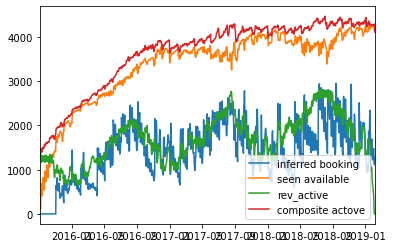

In [79]:
plt.plot(full_merge_tosave.groupby('res_date')['booked'].sum(), label='inferred booking')
plt.plot(full_merge_tosave.groupby('res_date')['seen_avail'].sum(), label='seen available')
plt.plot(full_merge_tosave.groupby('res_date')['rev_active'].sum(), label='rev_active')
plt.plot(full_merge_tosave.groupby('res_date')['composite_active'].sum(), label='composite actove')
plt.legend()
plt.xlim(full_merge_tosave.res_date.unique()[0], full_merge_tosave.res_date.unique()[-330])
plt.show()